# Radiation Sensitivity
**PAGE 683.** Here we consider the more basic problem of assessing the significance of the $p$ features. Consider the protein mass spectrometry example of Section 18.4.1. In that problem, the scientist might not be interested in predicting whether a given patient has prostate cancer. Rather the goal might be to identify proteins whose abundance differs between normal and cancer samples, in order to enhance understanding of the disease and suggest targets for drug development. Thus our goal is to assess the significance of individual features. This assessment is usually done without the use of a multivariate predictive model like those in the first part of this chapter. The feature assessment problem moves our focus from prediction to the traditional statistical topic of *multiple hypothesis testing*. For the remainder of this chapter we will use $M$ instead of $p$ to denote the number of features, since we will frequently be reffering to *p-values*.

Consider, for example, the microarray data in Table 18.4, taken from a study on the sensitivity of cancer patients to ionizing radiation treatment (Rieger et al., 2004). Each row consistis of the expression of genes in 58 patients samples: 44 samples were from patients with a normal reaction, and 14 from patients who had a severe reaction to radiation. The measurements were made on oligo-nucleotide microarrays. The object of the experiment was to find genes whose expression was different in the radiation sensitive group of patients.

**DATA INFO.** Gene expression for 12625 genes, one per row 58 samples (patients), one per column. Outcome for each of 58 patients; 1=not radiation sensitive, 2=radiation sensitive.

In [1]:
import numpy as np
from matplotlib import transforms, pyplot as plt
from scipy.stats import distributions

%matplotlib inline

# define commonly used colors
GRAY1, GRAY4, GRAY8 = '#231F20', '#646369', '#A6A6A5'
BLUE, ORANGE, RED = '#0000FF', '#FF8C00', '#FF2787'
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5

## Load and Prepare Data

In [2]:
data = np.load('../data/randsens.npz')['data']
sens_all = data[:, 1:]
sens_no = data[data[:, 0] == 1, 1:]
sens_yes = data[data[:, 0] == 2, 1:]

N1, M, N2 = *sens_no.shape, sens_yes.shape[0]
print(f'Normal: {N1}, Radiation Sensitive: {N2}, Features: {M}')

Normal: 44, Radiation Sensitive: 14, Features: 12625


## T-Test for the Means
**NOTE.** You can use *ttest_ind* method from the *scipy.stats* package. But it gives slightly different result from the book. So, lets implement our *ttest_ind*.

**PAGE 684.** To identify informative genes, we construct a two-sample t-statistic for each gene.
$$t_j = \frac{\bar{x}_{2j} + \bar{x}_{1j}}{se_j},$$
where $\bar{x}_{kj} = \sum_{i \in C_l}x_{ij}/N_l$. Hence $C_l$ are indices of the $N_l$ samples in group $l$, where $l=1$ is the normal group and $l=2$ is the sensitive group. The quantity $se_j$ is the pooled within-group standard error for gene $j$:
$$se_j=\hat{\sigma}_j\sqrt{\frac{1}{N_1} + \frac{1}{N_2}}; \hat{\sigma}^2_j=\frac{1}{N_1+N_2-2}(\sum_{i \in C_1}(x_{ij}-\bar{x}_{1j})^2 + \sum_{i \in C_2}(x_{ij} - \bar{x}_{2j})^2)$$

In [3]:
def my_ttest_ind(a, b):
    """
    Calculate the T-test on TWO RELATED samples of scores, a and b. This is a
    two-sided test for the null hypothesis that 2 related or repeated samples
    have identical average (expected) values.
    Parameters
    ----------
    a, b : array_like
        The arrays must have the same shape.
    Returns
    -------
    statistic : float or array
        t-statistic
    pvalue : float or array
        two-tailed p-value
    """
    x1_mean = np.mean(a, axis=0)
    x2_mean = np.mean(b, axis=0)
    var1 = np.sum(np.multiply((a - x1_mean).T, (a - x1_mean).T), axis=1)
    var2 = np.sum(np.multiply((b - x2_mean).T, (b - x2_mean).T), axis=1)
    variance = (var1 + var2)/(N1 + N2 - 2)
    se = np.sqrt(variance*(1/N1 + 1/N2))
    statistic = (x2_mean - x1_mean)/se
    pvalue = distributions.t.sf(np.abs(statistic), N1 + N2)*2
    return statistic, pvalue

In [4]:
# PAGE 685. If the tj values were normally distributed we could consider any
#           value greater than two in absolute value to be significantly large.
#           This would correspond to a significance level of about 5%. Here
#           there are 1189 genes with |tj|>=2. However with 12, 625 genes we
#           would expect many large values to occur by chance, even if the
#           grouping is unrelated to any gene.
t_stat, p_val = my_ttest_ind(sens_no, sens_yes)
np.sum(np.abs(t_stat) >= 2)

1189

## Permutations
**PAGE 685.** An attractive alternative approach is to use the permutation distribution, since it avoids assumption about the distribution of the data. We compute (in principle) all $K={58\choose 14}$ permutations of the sample labels, and for each permutation $k$ compute the t-statistics $t^k_j$. Then the p-value for gene $j$ is
$$p_j = \frac{1}{K}\sum_{k=1}^{K}I(|t^k_j|>|t_j|)$$

In [5]:
K, n_bins = 1000, 48
simulated_p_values = np.zeros(M)
simulated_t_hist = np.zeros(n_bins)

for i in range(K):
    perm = np.random.permutation(N1+N2)
    perm_sens_no = sens_all[perm[:N1]]
    perm_sens_yes = sens_all[perm[N1:]]
    perm_t_stat, _ = my_ttest_ind(perm_sens_no, perm_sens_yes)
    simulated_p_values += 1*(np.abs(perm_t_stat) > np.abs(t_stat))/K
    hist, bins = np.histogram(perm_t_stat, bins=np.linspace(-4.8, 5, n_bins+1))
    simulated_t_hist += hist/K

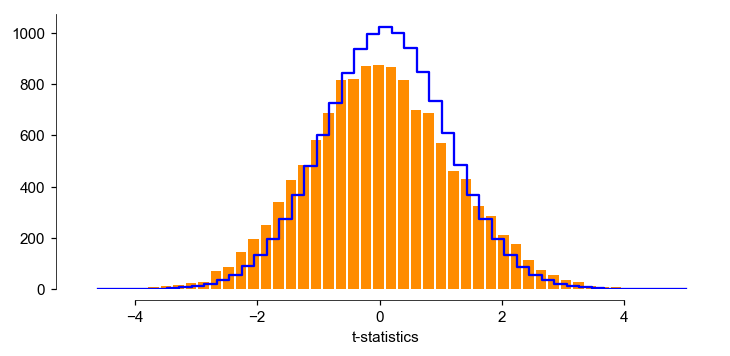

In [6]:
# PAGE 685. FIGURE 18.18 Radiation sensitivity microarray example. A histogram
#           of the 12,625 t-statistics comparing the radiation-sensitive versus
#           insensitive groups. Overlaid in blue is the histogram of the
#           t-statistics from 1000 permutations of the sample labels.
fig, ax = plt.subplots(figsize=(6, 2.5), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

ax.hist(t_stat, bins, color=ORANGE, width=0.17)
ax.step(bins[1:], simulated_t_hist, where='mid', color=BLUE)
ax.set_xlabel('t-statistics')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_bounds(-4, 4)

offset = transforms.ScaledTranslation(0, -0.1, fig.dpi_scale_trans)
for item in [ax.spines['bottom']] + ax.get_xticklabels() + \
             ax.xaxis.get_ticklines():
    item.set_transform(item.get_transform() + offset)

## Bonferroni Method
**PAGE 686.** One of the simplest approaches to multiple testing is the *Bonferroni* method. It makes each individual test more stringent, in order to make the FWER equal to at most $\alpha$: we rejrect $H_{0j}$ if $p_j < \alpha/M$. It is easy to show that the resulting FWER is $\le \alpha$ (Exercise 18.16). The Bonferroni method can be useful if $M$ is relatively small, but for large $M$ it is too conservative, that is, i calls too few genes significant.

In [7]:
# PAGE 686. In our example, if we test at level say a=0.05, the we must use the
#           threshold 0.05/12,625=3.9xE-6. None of the 12,625 genes had a
#           p-value this small.
np.sum(p_val < 0.05/M)

0

## Benjamini-Hochberg (BH) Method
**PAGE 687.** Here we instead focus on the *false discovery rate*
$$FDR=E(V/R)$$
In the microarray setting, this is the expected proportion of genes that are incorrectly called significant, among $R$ genes that are called significant.

**PAGE 687.** If the hypotheses are independant, Benjamini and Hochberg (1995) show that regardless of how many null hypotheses are true and regardless of the distribution of the p-values when the null hypotheses is false, this procedure has the property $$FDR \le \frac{M_0}{M}\alpha \le \alpha$$
For illustration we chose $\alpha = 0.15$. Figure 18.19 shows a plot of the ordered p-values $p_{(j)}$, and the line with slope $0.15/12625$.

In [8]:
# PAGE 689. Starting at the left and moving right, the BH method finds the last
#           time that the p-values fall below the line. This occurs at j = 11,
#           so we reject the 11 genes with smallest p-values.
alpha = 0.15
p_val_order = np.argsort(p_val)
decision_line = alpha*np.array(list(range(1, M+1)))/M
significant_cnt = np.argmin(p_val[p_val_order] < decision_line)
display_cnt = np.argmax(p_val[p_val_order] >= 0.005)
print(f'Rejected count: {significant_cnt}')

Rejected count: 11


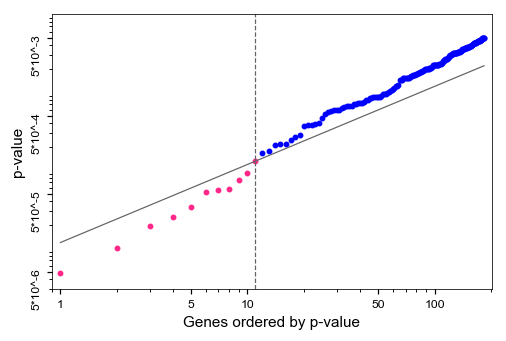

In [9]:
# PAGE 688. FIGURE 18.19. Microarray example continued. Shown is a plot of the
#           ordered p-values p(j) and the line 0.15*(j/12,625), for the
#           Benjamini-Hochberg method. The largest j for which the p-value p(j)
#           falls below the line, gives the BH threshold. Here this occurs at
#           j = 11, indicated by the vertical line. Thus the BH method calls
#           significant the 11 genes (in red) with smallest p-values.
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

ax.scatter(range(1, significant_cnt+1), p_val[p_val_order][:significant_cnt],
           s=8, color=RED)
ax.scatter(range(significant_cnt+1, display_cnt+1),
           p_val[p_val_order][significant_cnt:display_cnt],
           s=8, color=BLUE)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(0.3*10e-6, 0.01)
ax.set_xlim(0.9, display_cnt*1.1)
ax.plot(
    [1, display_cnt], [0.15/M, 0.15*display_cnt/M], color=GRAY4, linewidth=0.8)
ax.axvline(x=11, c=GRAY4, linewidth=0.8, linestyle='--')
ax.set_xlabel('Genes ordered by p-value')
ax.set_ylabel('p-value')
plt.setp(ax, xticks=[1, 5, 10, 50, 100],
         xticklabels=['1', '5', '10', '50', '100'],
         yticks=[5e-6, 5e-5, 5e-4, 5e-3],
         yticklabels=['5*10^-6', '5*10^-5', '5*10^-4', '5*10^-3'])
plt.yticks(rotation='vertical')
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(8)

## The Plug-in Estimate of the False Discovery Rate

In [10]:
# PAGE 689. A more direct way to proceed is a plug-in  approach. Rather than
#           starting with a value for a, we fix a cut-point for out
#           t-statistics, say the value 4.101 that appeared above. The number
#           of observed values |tj| equal or greater than 4.101 is 11. The
#           total number of permutation values |tjk| equal or greater than
#           4.101 is 1518, for an average of 1518/1000 = 1.518 per permutation.
#           Thus a direct estimate of the false discovery rate is
#           FDR = 1.518/11 ≈ 14%.
K, C = 1000, 4.101
R_obs, EV = np.sum(np.abs(t_stat) > C), 0
np.random.seed(4)
for i in range(K):
    perm = np.random.permutation(N1+N2)
    perm_sens_no = sens_all[perm[:N1]]
    perm_sens_yes = sens_all[perm[N1:]]
    perm_t_stat, _ = my_ttest_ind(perm_sens_no, perm_sens_yes)
    EV += (1/K)*np.sum(np.abs(perm_t_stat) > C)
FDR = EV/R_obs
print(f'FDR ≈ {FDR*100:.0f}%')

FDR ≈ 14%


## The SAM Procedure
**PAGE 690.** The *significance analysis of microarrays* (SAM) approach offers a way of doing this. The basis of the SAM method is shown in Figure 18.20. On the vertical axis we have plotted the ordered test statistics $t_{(1)} \le t_{(2)} \le ... \le t_{(M)}$, while the horizontal axis shows the expected order statistics from the permutations of the data: $\widetilde{t}_{(j)} = (1/K)\sum^K_{k=1}t^k_{(j)}$, where $t^k_{(1)} \le t^k_{(2)} \le ... \le t^k_{(M)}$ are the ordered test statistics from permutation $k$.

In [11]:
K, delta = 1000, 0.7
sim_t_stat = np.zeros(shape=t_stat.size)
np.random.seed(1)
for i in range(K):
    perm = np.random.permutation(N1+N2)
    perm_sens_no = sens_all[perm[:N1]]
    perm_sens_yes = sens_all[perm[N1:]]
    perm_t_stat, _ = my_ttest_ind(perm_sens_no, perm_sens_yes)
    sim_t_stat += 1/K * np.sort(perm_t_stat)

t_stat_order = np.argsort(t_stat)
significant_start = np.argmax(t_stat[t_stat_order] > sim_t_stat+delta)

Text(0,3.4,'Chi')

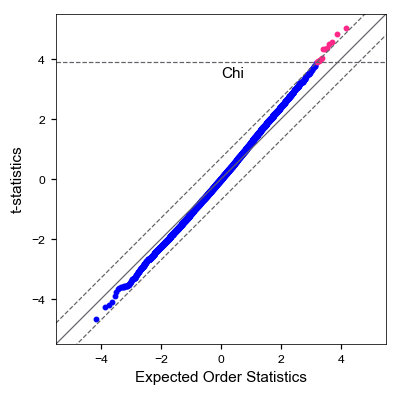

In [12]:
# PAGE 691. FIGURE 18.20. SAM plot for the radiation sensitivity microarray
#           data. On the vertical axis we have plotted the ordered test
#           statistics, while the horizontal axis shows the expected order
#           statistics of the test statistics from permutations of the data.
#           Two lines are drawn, parallel to the 45° line, Δ units away from
#           it. Starting at the origin and moving to the right, we find the
#           first place that the genes leave the band. This defines the upper
#           cut-point C-hi and all genes beyond that point are called
#           significant (marked in red). Similarly we define a lower cutpoint
#           C-low. For the particular value of Δ=0.71 in the plot, no genes are
#           called significant in the bottom left.
fig, ax = plt.subplots(figsize=(3, 3), dpi=110)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.scatter(sim_t_stat[:significant_start],
           t_stat[t_stat_order][:significant_start], s=8, color=BLUE)
ax.scatter(sim_t_stat[significant_start:],
           t_stat[t_stat_order][significant_start:], s=8, color=RED)
ax.plot([-5.5, 5.5], [-5.5, 5.5], color=GRAY4, linewidth=0.8)
ax.plot([-5.5, 5.5], [-5.5+delta, 5.5+delta], color=GRAY4, linewidth=0.8,
        linestyle='--')
ax.plot([-5.5, 5.5], [-5.5-delta, 5.5-delta], color=GRAY4, linewidth=0.8,
        linestyle='--')
ax.set_xlim(-5.5, 5.5)
ax.set_ylim(-5.5, 5.5)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(8)
ax.axhline(y=t_stat[t_stat_order][significant_start],
           c=GRAY4, linewidth=0.8, linestyle='--')
ax.set_xlabel('Expected Order Statistics')
ax.set_ylabel('t-statistics')
ax.text(0, 3.4, 'Chi')